DICE

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import dice_ml
from dice_ml.utils import helpers # helper functions
from dice_ml import Data,Model,Dice
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import time
import threading
from joblib import Parallel, delayed
#from langchain_experimental.agents import create_pandas_dataframe_agent
import os
import json
import openai
from openai import AzureOpenAI
#from langchain.llms import AzureOpenAI
#from langchain_openai import AzureChatOpenAI
import pandas as pd 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
xgb.set_config(verbosity=2)



KeyboardInterrupt: 

In [ ]:
dataframe_heart_disease = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

In [ ]:
dataframe_heart_disease =  dataframe_heart_disease.dropna()
dataframe_heart_disease =  dataframe_heart_disease.drop_duplicates()
dataframe_heart_disease = dataframe_heart_disease[dataframe_heart_disease['chol'] !=0]
dataframe_heart_disease = dataframe_heart_disease[dataframe_heart_disease['trestbps'] !=0]

In [ ]:
# Split the data into features and target label
y = dataframe_heart_disease.target
X = dataframe_heart_disease.drop(['target'], axis=1)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical = X_train.columns.difference(numerical)

In [ ]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])


In [ ]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', XGBClassifier())])
xgb_model = clf.fit(X_train, y_train)


In [ ]:
# create the pipeline with the XGBClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', transformations),
    ('classifier', XGBClassifier(max_depth=5, learning_rate=0.5, n_estimators=200, gamma=0))
])


In [ ]:
# train the model on the entire training set
xgb_pipeline = pipeline.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)


In [ ]:
X_high_risk_tp = X_test[(y_pred == 1) & (y_test == 1)].reset_index().drop(['index'], axis=1)
#X_high_risk_tp = X_test[(y_pred == 1) & (y_test == 1)]

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)


# Create a DICE data object
d = Data(dataframe=pd.DataFrame(train_data, columns=dataframe_heart_disease.columns), continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],outcome_name='target')

# Create a DICE model object
m = Model(model=xgb_pipeline, backend="sklearn")

Ideal Constraints

In [ ]:
import threading
import queue

df_no_counterfactuals = pd.DataFrame(columns=X_high_risk_tp.columns)
def generate_cf(test_instance, timeout=10):
    q = queue.Queue()

    def target():
        try:
            result = Dice(d, m, method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                                           features_to_vary=["trestbps", "chol", "fbs"],
                                                                           diversity_weight=5, proximity_weight=2, sparsity_weight=5,
                                                                           permitted_range={ "chol": [100, 200], "trestbps": [100, 120] }
                                                                           )
            q.put(result)
        except Exception as e:
            print("No counterfactuals found for test instance:", test_instance)
            df_no_counterfactuals.append(test_instance)
            q.put(None)

    # Start a new thread to run the target function
    thread = threading.Thread(target=target)
    thread.start()

    # Wait for the thread to finish or raise a timeout exception
    thread.join(timeout)

    if thread.is_alive():
        # The thread is still running, so raise a timeout exception
        print("No counterfactuals found for test instance-timed out:", test_instance)
        df_no_counterfactuals.append(test_instance)
        q.put(None)
    else:
        # The thread has finished, so return the result
        return q.get()

In [ ]:

exps_ideal = []
num_cores = -1

# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(1))
    exps_ideal.append(exp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [ ]:
validity_list = []
for exps in exps_ideal:
    
    if exps[0] is not None:
       exp_df = exps[0].cf_examples_list[0].final_cfs_df
       validity_list.append(xgb_pipeline.predict(exp_df))

In [ ]:

# Flatten the nested array
flattened_array = [item for sublist in validity_list for item in sublist]

# Calculate the sum of 1s
sum_of_ones = sum(item == 1 for item in flattened_array)

print("Flattened Array:", flattened_array)
print("Sum of 1s:", sum_of_ones)

Flattened Array: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Feasible Constraints

In [ ]:
import threading
import queue

df_no_counterfactuals = pd.DataFrame(columns=X_high_risk_tp.columns)
def generate_cf_feasible(test_instance, timeout=30):
    q = queue.Queue()

    def target():
        try:
            result = Dice(d, m, method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                                           features_to_vary=["trestbps", "chol", "fbs"],
                                                                           #diversity_weight=5, proximity_weight=2, sparsity_weight=5,
                                                                           permitted_range={"trestbps": [80, test_instance['trestbps'].values[0]-10],
                                                                                            "chol": [100, test_instance['chol'].values[0]-0.1*test_instance['chol'].values[0]],
                                                                                           }
                                                                           )
            q.put(result)
        except Exception as e:
            print("No counterfactuals found for test instance:", test_instance)
            df_no_counterfactuals.append(test_instance)
            q.put(None)

    # Start a new thread to run the target function
    thread = threading.Thread(target=target)
    thread.start()

    # Wait for the thread to finish or raise a timeout exception
    thread.join(timeout)

    if thread.is_alive():
        # The thread is still running, so raise a timeout exception
        print("No counterfactuals found for test instance-timed out:", test_instance)
        df_no_counterfactuals.append(test_instance)
        q.put(None)
    else:
        # The thread has finished, so return the result
        return q.get()

In [ ]:

exps_feasible = []
num_cores = -1

# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf_feasible)(test_instance) for i in range(1))
    exps_feasible.append(exp)

General Counterfactuals

In [ ]:
import threading
import queue

df_no_counterfactuals = pd.DataFrame(columns=X_high_risk_tp.columns)
def generate_cf_feasible_(test_instance, timeout=30):
    q = queue.Queue()

    def target():
        try:
            result = Dice(d, m, method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                                           features_to_vary=["trestbps", "chol", "thalach"],
                                                                           #diversity_weight=5, proximity_weight=2, sparsity_weight=5,
                                                                           #permitted_range={"trestbps": [80, test_instance['trestbps'].values[0]-1],
                                                                           #                 "chol": [100, test_instance['chol'].values[0]-1],
                                                                           #                 "thalach": [test_instance['thalach'].values[0]+1, 220 - test_instance['age'].values[0]]}
                                                                           )
            q.put(result)
        except Exception as e:
            print("No counterfactuals found for test instance:", test_instance)
            df_no_counterfactuals.append(test_instance)
            q.put(None)

    # Start a new thread to run the target function
    thread = threading.Thread(target=target)
    thread.start()

    # Wait for the thread to finish or raise a timeout exception
    thread.join(timeout)

    if thread.is_alive():
        # The thread is still running, so raise a timeout exception
        print("No counterfactuals found for test instance-timed out:", test_instance)
        df_no_counterfactuals.append(test_instance)
        q.put(None)
    else:
        # The thread has finished, so return the result
        return q.get()

In [ ]:

exps_feasible_ = []
num_cores = -1

# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf_feasible_)(test_instance) for i in range(1))
    exps_feasible_.append(exp)

Structural Causal Model

In [1]:
df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

NameError: name 'pd' is not defined

In [127]:
df = df.drop_duplicates(keep='first')

In [128]:
def bin_oldpeak(oldpeak):
    if oldpeak <= 1:
        return 0
    elif oldpeak > 1 and oldpeak <= 2:
        return 1
    elif oldpeak > 2 and oldpeak <= 3:
        return 2
    else:
        return 3


In [129]:
df['oldpeak'] = df['oldpeak'].apply(bin_oldpeak)

In [130]:
df =  df.dropna()
df = df[df['chol'] >0]
df = df[df['trestbps'] >0]
#df = df[df['oldpeak'] >=0]

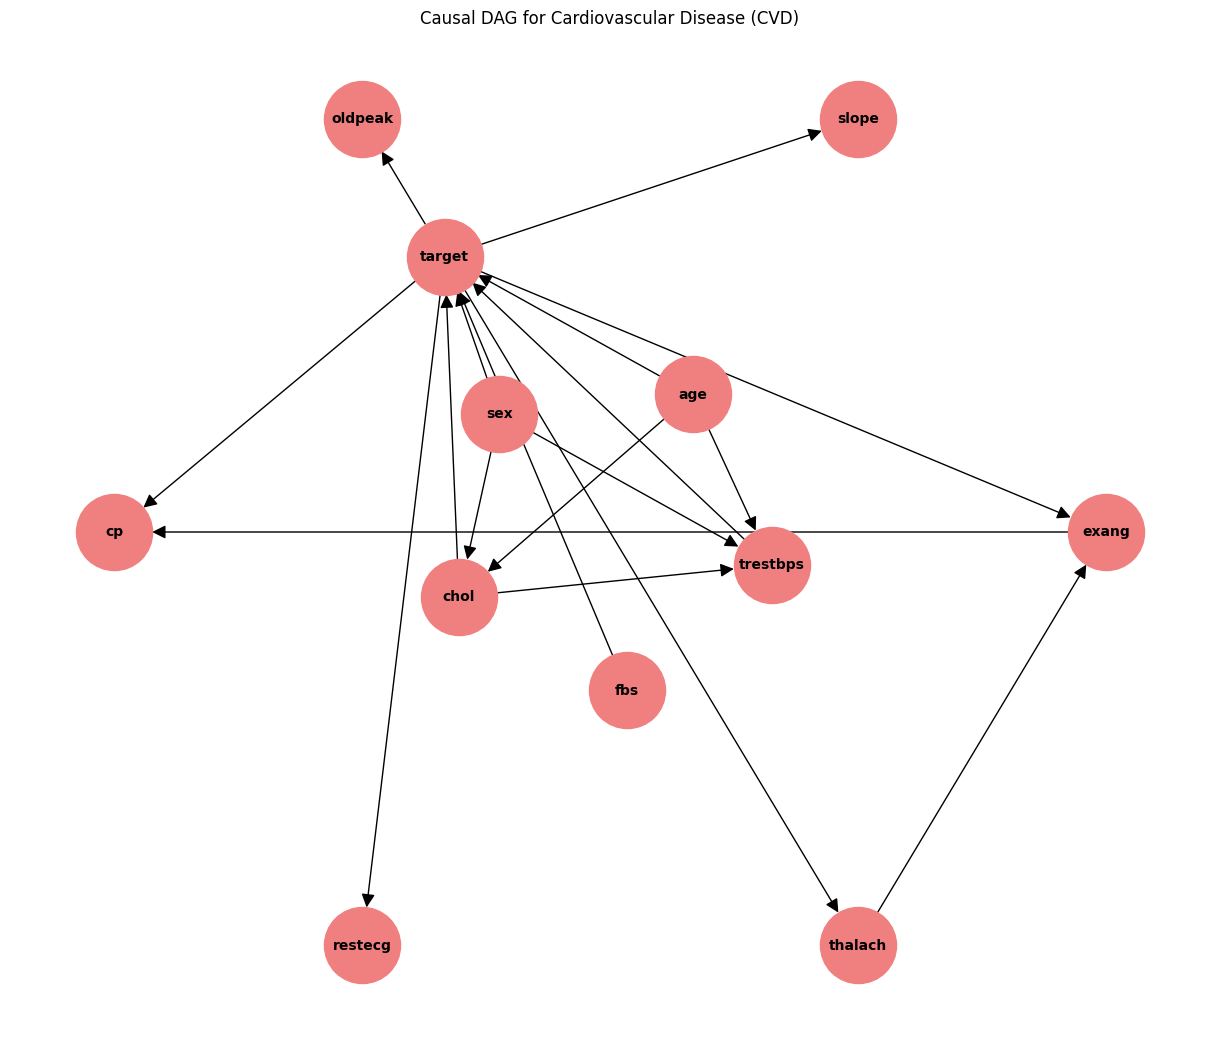

In [131]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the three layers: Risk Factors, Diseases, Symptoms
risk_factors = ['age', 'sex', 'chol', 'fbs', 'trestbps']
diseases = ['target']  # Heart disease
symptoms = ['cp', 'restecg', 'thalach', 'exang', 'slope','oldpeak']

# Add causal relationships: Risk Factors -> Diseases
for rf in risk_factors:
    G.add_edge(rf, 'target')

# Add causal relationships: Diseases -> Symptoms
for sym in symptoms:
    G.add_edge('target', sym)

# Add some direct Risk Factors -> Symptoms relationships
#G.add_edge('age', 'cp')
G.add_edge('age', 'chol')
G.add_edge('age', 'trestbps')
G.add_edge('sex', 'trestbps')
G.add_edge('sex', 'chol')
G.add_edge('chol', 'trestbps')
G.add_edge('thalach', 'exang')
G.add_edge('exang', 'cp')
#G.add_edge('fbs', 'oldpeak')

# Use shell_layout for a circular arrangement of nodes
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G, nlist=[risk_factors, diseases, symptoms])

# Draw the graph with shell layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightcoral', font_size=10, font_weight='bold', arrowsize=20)

# Display the graph
plt.title('Causal DAG for Cardiovascular Disease (CVD)')
plt.show()


In [132]:
df['target'] = df['target'].astype('category')
df['exang'] = df['exang'].astype('category')
df['fbs'] = df['fbs'].astype('category')
df['cp'] = df['cp'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['slope'] = df['slope'].astype('category')
df['sex'] = df['sex'].astype('category')
df['oldpeak'] = df['oldpeak'].astype('category')

In [133]:
from dowhy import gcm
causal_model = gcm.InvertibleStructuralCausalModel(G)

In [ ]:
gcm.auto.assign_causal_mechanisms(causal_model, df)

In [105]:
gcm.fit(causal_model, df)


Fitting causal mechanism of node oldpeak: 100%|██████████| 12/12 [00:00<00:00, 228.50it/s]


In [106]:
gcm.evaluate_causal_model(causal_model, df)  

Test permutations of given graph: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


CausalModelEvaluationResult(mechanism_performances={'age': MechanismPerformanceResult(), 'sex': MechanismPerformanceResult(), 'fbs': MechanismPerformanceResult(), 'chol': MechanismPerformanceResult(), 'trestbps': MechanismPerformanceResult(), 'target': MechanismPerformanceResult(), 'restecg': MechanismPerformanceResult(), 'thalach': MechanismPerformanceResult(), 'slope': MechanismPerformanceResult(), 'oldpeak': MechanismPerformanceResult(), 'exang': MechanismPerformanceResult(), 'cp': MechanismPerformanceResult()}, pnl_assumptions={'target': (0.0, True, 0.05), 'chol': (1.0, False, 0.05), 'trestbps': (1.0, False, 0.05), 'cp': (0.0, True, 0.05), 'restecg': (0.015555123851972663, True, 0.05), 'thalach': (1.0, False, 0.05), 'exang': (0.0, True, 0.05), 'slope': (2.892616146610294e-09, True, 0.05), 'oldpeak': (0.0, True, 0.05)}, graph_falsification=+-------------------------------------------------------------------------------------------------------+
|                                      

In [107]:
X_high_risk_tp = X_high_risk_tp.assign(target=1)
df_high_risk_tp = X_high_risk_tp

In [108]:
df_high_risk_tp.to_csv("df_high_risk_tp.csv", index=False)

In [109]:
df_high_risk_tp[3:4]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
3,55,1,4,158,217,0,0,110,1,2.5,2,1


In [ ]:
for i in range(len(df_high_risk_tp)):
    df_risk = df_high_risk_tp.iloc[[i]]
    # Apply the filtering conditions
    age = df_risk['age']
    chol_risk = df_risk['chol']
    trestbps_risk = df_risk['trestbps']
    print("\nOriginal DataFrame:")
    print(df_risk)
    
    exp = exps_ideal[i]
    if exp[0] is not None:
        df_cf = exp[0].cf_examples_list[0].final_cfs_df
        
        for j in range(len(df_cf)):
            cf_chol = df_cf['chol'].iloc[j]
            cf_trestbps = df_cf['trestbps'].iloc[j] if 'trestbps' in df_cf.columns else None
            
            # Check if 'chol' and 'target' are not None
            if pd.notna(cf_chol) and df_risk['target'].notna().all():
                intervention_dict = {'chol': lambda chol: cf_chol}
            elif pd.isna(cf_chol) and pd.notna(cf_trestbps) and df_risk['target'].notna().all():
                intervention_dict = {'trestbps': lambda trestbps: cf_trestbps}
            else:
                print("chol or target is None")
                continue

            cf_samples = gcm.interventional_samples(causal_model, intervention_dict, observed_data=df_risk)
            cf_samples['exang'] = cf_samples['exang'].clip(0, 1).astype('category')
            cf_samples_filtered = cf_samples[
                (cf_samples['chol'] < chol_risk)
                                   
            ]
            
            # Check if any of the target values in filtered cf_samples are 0
            if (cf_samples_filtered['target'] == 0).any():
                # Filter the counterfactual samples that resulted in target = 0
                cf_worked = cf_samples_filtered[cf_samples_filtered['target'] == 0]
                for index, row in cf_worked.iterrows():
                    print("\nCounterfactual DataFrame:")
                    print(cf_samples_filtered)
                    print("\nCholesterol Level:", row['chol'])
                    print("Trestbps Level:", row['trestbps'])


Original DataFrame:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   59    1   1       160   273    0        2      125      0      0.0      1   

   target  
0       1  

Counterfactual DataFrame:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   59    1   3       100   173    0        1      160      0        0      1   

   target  
0       0  

Cholesterol Level: 173
Trestbps Level: 100

Counterfactual DataFrame:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   59    1   4        95   172    0        0      140      0        0      1   

   target  
0       0  

Cholesterol Level: 172
Trestbps Level: 95

Original DataFrame:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
1   50    1   3       140   233    0        0      163      0      0.6      2   

   target  
1       1  

Original DataFrame:
   age  sex  cp  trestbps  chol  fbs  restecg  t

In [ ]:
'''for i in range(len(df_high_risk_tp)):
    df_risk = df_high_risk_tp.iloc[[i]]
    # Apply the filtering conditions
    age = df_risk['age']
    chol_risk = df_risk['chol']
    thalach_risk = df_risk['thalach']
    print("\nOriginal DataFrame:")
    print(df_risk)
    
    exp = exps_ideal[i]
    if exp[0] is not None:
        df_cf = exp[0].cf_examples_list[0].final_cfs_df
        
        for j in range(len(df_cf)):
            cf_chol = df_cf['chol'].iloc[j]
            cf_thalach = df_cf['thalach'].iloc[j]
            
            # Check if 'chol' and 'target' are not None
            if pd.notna(cf_chol) and pd.notna(cf_thalach) and df_risk['target'].notna().all():
                cf_samples = gcm.interventional_samples(causal_model, {'chol': lambda chol: cf_chol, 'thalach': lambda thalach: cf_thalach}, observed_data=df_risk)
                cf_samples['exang'] = cf_samples['exang'].clip(0, 1).astype('category')
                
               
                
                cf_samples_filtered = cf_samples[
                    (cf_samples['chol'] < chol_risk)                     
                ]
                
                # Check if any of the target values in filtered cf_samples are 0
                if (cf_samples_filtered['target'] == 0).any():
                    # Filter the counterfactual samples that resulted in target = 0
                    cf_worked = cf_samples_filtered[cf_samples_filtered['target'] == 0]
                    for index, row in cf_worked.iterrows():
                        print("\nCounterfactual DataFrame:")
                        print(cf_samples_filtered)
                        print("\nCholesterol Level:", row['chol'])
                        print("Thalach Level:", row['thalach'])
            else:
                print("chol or target is None")'''

In [ ]:
for i in range(len(df_high_risk_tp)):
    df_risk = df_high_risk_tp.iloc[[i]]
    # Apply the filtering conditions
    age = df_risk['age']
    chol_risk = df_risk['chol']
    thalach_risk = df_risk['thalach']
    print("\nOriginal DataFrame:")
    print(df_risk)
    
    exp = exps_feasible[i]
    if exp[0] is not None:
        df_cf = exp[0].cf_examples_list[0].final_cfs_df
        
        for j in range(len(df_cf)):
            cf_chol = df_cf['chol'].iloc[j]
            cf_thalach = df_cf['thalach'].iloc[j]
            
            # Check if 'chol' and 'target' are not None
            if pd.notna(cf_chol) and pd.notna(cf_thalach) and df_risk['target'].notna().all():
                cf_samples = gcm.interventional_samples(causal_model, {'chol': lambda chol: cf_chol, 'thalach': lambda thalach: cf_thalach}, observed_data=df_risk)
                cf_samples['exang'] = cf_samples['exang'].clip(0, 1).astype('category')
                
               
                
                cf_samples_filtered = cf_samples[
                    (cf_samples['chol'] < chol_risk) &
                    (cf_samples['thalach'] > thalach_risk) &
                    (cf_samples['thalach'] < (220 - age))
                ]
                
                # Check if any of the target values in filtered cf_samples are 0
                if (cf_samples_filtered['target'] == 0).any():
                    # Filter the counterfactual samples that resulted in target = 0
                    cf_worked = cf_samples_filtered[cf_samples_filtered['target'] == 0]
                    for index, row in cf_worked.iterrows():
                        print("\nCounterfactual DataFrame:")
                        print(cf_samples_filtered)
                        print("\nCholesterol Level:", row['chol'])
                        print("Thalach Level:", row['thalach'])
            else:
                print("chol or target is None")

In [ ]:
for i in range(len(df_high_risk_tp)):
    df_risk = df_high_risk_tp.iloc[[i]]
    # Apply the filtering conditions
    age = df_risk['age']
    chol_risk = df_risk['chol']
    thalach_risk = df_risk['thalach']
    print("\nOriginal DataFrame:")
    print(df_risk)
    
    exp = exps_feasible_[i]
    if exp[0] is not None:
        df_cf = exp[0].cf_examples_list[0].final_cfs_df
        
        for j in range(len(df_cf)):
            cf_chol = df_cf['chol'].iloc[j]
            cf_thalach = df_cf['thalach'].iloc[j]
            
            # Check if 'chol' and 'target' are not None
            if pd.notna(cf_chol) and pd.notna(cf_thalach) and df_risk['target'].notna().all():
                cf_samples = gcm.interventional_samples(causal_model, {'chol': lambda chol: cf_chol, 'thalach': lambda thalach: cf_thalach}, observed_data=df_risk)
                cf_samples['exang'] = cf_samples['exang'].clip(0, 1).astype('category')
                
               
                
                cf_samples_filtered = cf_samples[
                    (cf_samples['chol'] < chol_risk) &
                    (cf_samples['thalach'] > thalach_risk) &
                    (cf_samples['thalach'] < (220 - age))
                ]
                
                # Check if any of the target values in filtered cf_samples are 0
                if (cf_samples_filtered['target'] == 0).any():
                    # Filter the counterfactual samples that resulted in target = 0
                    cf_worked = cf_samples_filtered[cf_samples_filtered['target'] == 0]
                    for index, row in cf_worked.iterrows():
                        print("\nCounterfactual DataFrame:")
                        print(cf_samples_filtered)
                        print("\nCholesterol Level:", row['chol'])
                        print("Thalach Level:", row['thalach'])
            else:
                print("chol or target is None")

In [ ]:
for i in range(len(df_high_risk_tp)):
    df_risk = df_high_risk_tp.iloc[[i]]
    print("\nOriginal DataFrame:")
    print(df_risk)
    
    exp = exps_ideal[i]
    if exp[0] is not None:
        df_cf = exp[0].cf_examples_list[0].final_cfs_df
        
        for j in range(len(df_cf)):
            cf_chol = df_cf['chol'].iloc[j]
            cf_thalach = df_cf['thalach'].iloc[j]
            
            # Check if 'chol' and 'target' are not None
            if pd.notna(cf_chol) and pd.notna(cf_thalach) and df_risk['target'].notna().all():
                cf_samples = gcm.interventional_samples(causal_model, {'chol': lambda chol: cf_chol, 'thalach': lambda thalach: cf_thalach}, observed_data=df_risk)
                cf_samples['exang'] = cf_samples['exang'].clip(0, 1).astype('category')
                
                # Check if any of the target values in cf_samples are 0
                if (cf_samples['target'] == 0).any():
                    # Filter the counterfactual samples that resulted in target = 0
                    cf_worked = cf_samples[cf_samples['target'] == 0]
                    for index, row in cf_worked.iterrows():
                        print("\nCounterfactual DataFrame:")
                        print(cf_samples)
                        print("\nCholesterol Level:", row['chol'])
                        print("Thalach Level:", row['thalach'])
            else:
                print("chol or target is None")

In [ ]:
df_high_risk_tp[3:4]

In [33]:

samples_chol = gcm.interventional_samples(causal_model, {'chol': lambda chol:208,'thalach': lambda thalach:159}, observed_data=df_high_risk_tp[3:4])

In [ ]:
df_high_risk_tp[3:4]

In [ ]:
samples_chol

In [ ]:
samples['exang'] = samples['exang'].clip(0, 1).astype('category')

In [ ]:
# Ensure both DataFrames have the same index
df_risk = df_risk.reset_index(drop=True)
samples = samples.reset_index(drop=True)

# Find rows where exang has changed from 1 to 0
changed_rows = df_risk[(df_risk['exang'] == 1) & (samples['exang'] == 0)]

# Display the rows
print(changed_rows)

In [ ]:
print(samples['target'].value_counts())


In [ ]:
samples_chol

In [ ]:
# Update 'sex' column
df['sex'] = df['sex'].replace({1: 'Male', 0: 'Female'})
# Update 'cp' column
df['cp'] = df['cp'].replace({1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 4: 'asymptomatic'})
# Update 'fbs' column
df['fbs'] = df['fbs'].replace({1: 'True', 0: 'False'})
# Update 'restecg' column
df['restecg'] = df['restecg'].replace({0: 'normal', 1: 'ST-T wave abnormality', 2: 'probable or definite left ventricular hypertrophy'})
# Update 'exang' column
df['exang'] = df['exang'].replace({1: 'yes', 0: 'no'})
# Update 'slope' column
df['slope'] = df['slope'].replace({1: 'upsloping', 2: 'flat', 3: 'downsloping'})
# Update 'target' column
df['target'] = df['target'].replace({1: 'yes', 0: 'no'})

In [ ]:
df_risk = df[df['target'] == 'yes'].reset_index(drop=True)

In [ ]:

def read_data():
    dict_strings = []
    df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")
    # Update 'sex' column
    df['sex'] = df['sex'].replace({1: 'Male', 0: 'Female'})
    # Update 'cp' column
    df['cp'] = df['cp'].replace({1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 4: 'asymptomatic'})
    # Update 'fbs' column
    df['fbs'] = df['fbs'].replace({1: 'True', 0: 'False'})
    # Update 'restecg' column
    df['restecg'] = df['restecg'].replace({0: 'normal', 1: 'ST-T wave abnormality', 2: 'probable or definite left ventricular hypertrophy'})
    # Update 'exang' column
    df['exang'] = df['exang'].replace({1: 'yes', 0: 'no'})
    # Update 'slope' column
    df['slope'] = df['slope'].replace({1: 'upsloping', 2: 'flat', 3: 'downsloping'})
    # Update 'target' column
    df['target'] = df['target'].replace({1: 'yes', 0: 'no'})
    df_risk = df[df['target'] == 'yes'].reset_index(drop=True)
    for i in range(len(df_risk)):
        patient_records = df_risk.iloc[i]
        dict_string = json.dumps(patient_records.to_dict())
        dict_strings.append(dict_string)
    return dict_strings


In [ ]:
Dataset_Description = """age: This is the patient’s age, measured in years.
10
2. sex: This variable indicates the patient’s gender, with 1 signifying
Male and 0 signifying Female.
3. cp: This attribute describes the kind of chest discomfort experienced
by the patient, with 1 indicating typical angina, 2 indicating atypical
angina, 3 indicating non-anginal pain, and four indicating asymptomatic.
4. trestbps: Upon hospital admission, the patient’s resting blood pressure
(in mmHg).
5. chol: This variable measures the patient’s cholesterol level in mg/dl.
6. fbs: This attribute indicates whether the patient’s fasting blood sugar
level exceeds 120 mg/dl (1 = True; 0 = False).
7. restecg: This variable represents the resting electrocardiographic measurement,
with 0 indicating normal, 1 indicating ST-T wave abnormality,
and 2 indicating probable or definite left ventricular hypertrophy
by Estes’ criteria.
8. thalach: This attribute denotes the maximum heart rate the individual
achieves during exercise.
9. exang: This variable indicates whether the patient experienced angina
caused by exercise (1 = yes; 0 = no).
10. oldpeak: This attribute refers to the ST depression induced by exercise
relative to rest (‘ST’ refers to positions on the ECG plot).
11. slope: This variable describes the slope of the peak exercise ST segment
(1: upsloping, 2: flat, 3: downsloping).
12. target: This attribute indicates whether the patient has heart disease/
CVD (0 = no, 1 = yes)."""

In [ ]:
import openai
import json
import os
import concurrent.futures
import time

openai.api_type = "azure"
openai.api_base = "https://dap-open-ai-swc.openai.azure.com/"
openai.api_version = "2023-09-15-preview"
openai.api_key = "1fc75eeca3934ae29b46d59cfda85968"

client = AzureOpenAI( azure_endpoint = "https://dap-open-ai-swc.openai.azure.com/", 
                    api_key= "1fc75eeca3934ae29b46d59cfda85968",  
                    api_version="2023-05-15"
                    )

    
def create_patient_description (patient_record):
    # Convert the patient record to a dictionary string
    
    #print(i)
    dict_string = json.dumps(patient_record)

    # Create the message text
    message_text = [{
        "role": "system",
        "content": f"""You are a helpful assistant. Here is the dataset description {Dataset_Description}.
        Describe this patient info
        ---
        {dict_string} 
        ---
        in plain english for me. Be precise and concise.
        """}]

    # Create the chat completion
    completion = client.chat.completions.create(
        model="gpt-4-32k-deployment",
        messages=message_text,
        temperature=0.0,
        max_tokens=800,
        top_p=0.95,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    # Return the generated description
    return completion.choices[0].message.content




def create_patient_description_with_retry(patient_record):
    retries = 0
    while True:
        try:
            return create_patient_description(patient_record)
        except Exception as e:
            if '429' in str(e):
                print(f"Rate limit exceeded. Retrying after {2**retries} seconds.")
                time.sleep(2**retries)
                retries += 1
            else:
                print(f"An error occurred: {e}")
                return None

def create_patient_descriptions(patient_records):
    # Create a thread pool executor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        patient_descriptions = list(executor.map(create_patient_description_with_retry, patient_records))

    return patient_descriptions

In [ ]:
patient_records = read_data()
patient_descriptions = create_patient_descriptions(patient_records)

In [ ]:
len(patient_descriptions)

In [ ]:
patient_info = patient_descriptions[11]

In [ ]:
patient_info

In [ ]:
 def create_patient_cf (patient_record):
    # Convert the patient record to a dictionary string 
    client = AzureOpenAI( azure_endpoint = "https://dap-open-ai-swc.openai.azure.com/", 
                        api_key= "1fc75eeca3934ae29b46d59cfda85968",  
                        api_version="2023-05-15"
                        )

    message_text = [{"role":"system",
        "content":f"""You are a helpful assistant in Counterfactual Reasoning.
        Here are the patient details:
        --- 
        {patient_record}
        ---
        What should the patient do specifically to prevent heart disease?
        Answer in precise comma separated manner in the following format:
        ---
        {{"Preventive Measures": ["(measure1:value1), (measure2:value2),..."]}}
        ---
        Restrict the preventive measures based on the patient's health data provided to you. Restrict actionable insights to Cholestrol, Resting Blood Pressure, Max Heart Rate and fasting blood sugar levels.
        Here are the constraints. The counterfactual cholestrol should be lesser than patient's Cholestrol cannot be greater than 200.
        Counterfactual Resting Blood Pressure and should be lesser than patient's Resting Blood Pressure and cannot be greater than 120. 
        Counterfactual Max heat rate should be greater than patient's current max heart rate should be lower than 220-Age.
        Give a specific number for each preventive measure. Do not hallucinate. Don't provide general advice and say don't know if you can't provide a specific number.
        """}]

    completion = client.chat.completions.create(
            model="gpt-4-32k-deployment",
            messages=message_text,
            temperature=0.0,
            max_tokens=800,
            top_p=0.95,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None
        )
    
    return completion.choices[0].message.content



In [ ]:
 def create_patient_cf_wo_constraints (patient_record):
    # Convert the patient record to a dictionary string 
    client = AzureOpenAI( azure_endpoint = "https://dap-open-ai-swc.openai.azure.com/", 
                        api_key= "1fc75eeca3934ae29b46d59cfda85968",  
                        api_version="2023-05-15"
                        )

    message_text = [{"role":"system",
        "content":f"""You are a helpful assistant in Counterfactual Reasoning.
        Here are the patient details:
        --- 
        {patient_record}
        ---
        What should the patient do specifically to prevent heart disease?
        Answer in precise comma separated manner in the following format:
        ---
        {{"Preventive Measures": ["(measure1:value1), (measure2:value2),..."]}}
        ---
        Restrict the preventive measures based on the patient's health data provided to you. Restrict actionable insights to Cholestrol, Resting Blood Pressure, Max Heart Rate and fasting blood sugar levels.
        Give a specific number for each preventive measure. Do not hallucinate. Don't provide general advice and say don't know if you can't provide a specific number.
        """}]

    completion = client.chat.completions.create(
            model="gpt-4-32k-deployment",
            messages=message_text,
            temperature=0.0,
            max_tokens=800,
            top_p=0.95,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None
        )
    
    return completion.choices[0].message.content



In [ ]:
patient_cvd_counterfactual_wo_constraints = []
for idx,patient_record in enumerate(patient_descriptions):
    print(idx)
    patient_cvd_counterfactual_wo_constraints.append(create_patient_cf_wo_constraints(patient_record))

In [ ]:
patient_cvd_counterfactual_wo_constraints

In [ ]:
patient_cvd_counterfactual = []
for idx,patient_record in enumerate(patient_descriptions):
    print(idx)
    patient_cvd_counterfactual.append(create_patient_cf(patient_record))

In [ ]:
# Add 'patient_descriptions' and 'patient_cvd_counterfactual' to 'df_risk'
df_risk['patient_descriptions'] = patient_descriptions
df_risk['patient_cvd_counterfactual'] = patient_cvd_counterfactual

# Save 'df_risk' as a CSV file
df_risk.to_csv('df_risk_3.csv', index=False)

In [ ]:
# Extract the values for each preventive measure and put them into separate columns
df_risk['Cholesterol'] = df_risk['patient_cvd_counterfactual'].str.extract(r'Cholesterol\s*:\s*(\d+)')
df_risk['Resting Blood Pressure'] = df_risk['patient_cvd_counterfactual'].str.extract(r'Resting Blood Pressure\s*:\s*(\d+)')
df_risk['Max Heart Rate'] = df_risk['patient_cvd_counterfactual'].str.extract(r'Max Heart Rate\s*:\s*(\d+)')
df_risk['Fasting Blood Sugar'] = df_risk['patient_cvd_counterfactual'].str.extract(r'Fasting Blood Sugar\s*:\s*(\d+)')

In [ ]:
df_risk.head()

In [ ]:
# Get descriptive statistics of the 'Cholesterol', 'Resting Blood Pressure', and 'Max Heart Rate' columns
df_risk[['Cholesterol', 'Resting Blood Pressure', 'Max Heart Rate']].describe()

In [ ]:
# Convert the list into a DataFrame
df = pd.DataFrame(patient_cvd_counterfactual, columns=['preventive_measures'])

# Split the 'preventive_measures' column into separate columns
df = df['preventive_measures'].str.split(',', expand=True)

Necessary and Sufficient Causes

In [ ]:
#Note: The openai-python library support for Azure OpenAI is in preview.
      #Note: This code sample requires OpenAI Python library version 0.28.1 or lower.
import os
import openai

openai.api_type = "azure"
openai.api_base = "<OpenAI url>"
openai.api_version = "2023-07-01-preview"
openai.api_key = "<key>"
necessary_cause = "Causes"  # replace with actual necessary causes
sufficient_cause = "Causes"  # replace with actual sufficient causes

cause_dict = {"Necessary Cause": necessary_cause, "Sufficient Cause": sufficient_cause}

message_text = [{"role":"system",
"content":f"""You are an expert in Causal Reasoning (Actual Causality). Your aware of the INUS Causation.
Here are the patient details:
--- 
{patient_info}
---
Provide necessary and sufficient cause(s) for the patient's heart disease separately.
Answer with medical explantions in precise manner in the following format:
---
{cause_dict}
---
"""}]

completion = openai.ChatCompletion.create(
  engine="gpt-4-32k-deployment",
  messages = message_text,
  temperature=0.0,
  max_tokens=800,
  top_p=0.95,
  frequency_penalty=0,
  presence_penalty=0,
  stop=None
)

In [ ]:
print(completion.choices[0].message.content)

Responsibility

In [ ]:
#Note: The openai-python library support for Azure OpenAI is in preview.
      #Note: This code sample requires OpenAI Python library version 0.28.1 or lower.
import os
import openai

openai.api_type = "azure"
openai.api_base = "https://dap-open-ai-swc.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = "1fc75eeca3934ae29b46d59cfda85968"

message_text = [{"role":"system","content":f"""
In the context of this dialog, define “responsibility” as the relative degree to which an event causally
contributes to a particular outcome event, relative to
other events that caused that outcome. Given two
causal events that cause the same outcome event, one
causal event can be more, less, or equally responsible
relative to the other. In medical cases, the responsibility should be action-based.

Based on this definition of responsibility and the patient info:{patient_info}, answer precisely which factor is/are most responsible for his/her of heart disease."""}]

completion = openai.ChatCompletion.create(
  engine="gpt-4-32k-deployment",
  messages = message_text,
  temperature=0.0,
  max_tokens=800,
  top_p=0.95,
  frequency_penalty=0,
  presence_penalty=0,
  stop=None
)

In [ ]:
print(completion.choices[0].message.content)